Twoim celem jest zbudowanie modelu regresji, który objaśni zmienność masy ciała pingwina w gramach.



1) Pamiętaj żeby prawidłowo wczytać dane, dopilnuj aby ich typy nadawały się do analizy.



2) Pierwszy model sformułuj przy pomocy regresji liniowej  wykorzystując wszystkie pozostałe zmienne z pliku.



3) Zapisz model regresi liniowej wg schematu:



 y = B1X1 + B1X2 + ... BnXn + ε



    Zinterpretuj parametry Beta.



4) Zinterpretuj parametry modelu jak:

istotność poszczególnych zmiennych Pr(>|t|) ,
R-kwadrat,
wartość p modelu.


5) Stwórz wykres rozrzutu dla reszt  modelu.  Poczytaj samodzielnie i spróbuj orzec o homo / hetero schedastyczności modelu (dowolna metoda).



6) Dokonaj predykcji modelu dla przypadku:

pingwin maskowy,
samiec,
długośc dzioba 46 mm,
szerokość 21 mm,
długość płetwy 210 mm.


7) Zbuduj ręcznie dowolny model konkurencyjny:

dowolna metoda regresji,
dowolne parametry,
R2 >= 0.75.


8) Porównaj wyniki modeli. Napisz, który jest lepszy dla predykcji i dlaczego.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import seaborn as sns
import os

import sklearn
from sklearn.compose import ColumnTransformer
from xarray.core.formatting import last_n_items

seaborn.set_theme(context='notebook',palette='inferno',style='darkgrid')

In [2]:
#Wczytanie danych
# URL do surowego pliku CSV na GitHubie
url = "https://raw.githubusercontent.com/MichauJ/Learning-ML/refs/heads/main/pingwiny.csv"
df = pd.read_csv(url,sep=';',header=0,decimal=',')

In [5]:
#zmiana nazw kolumn i wartości płci na krótsze, dla poprawienia przejrzystości
df.rename(columns={
    "dlugosc_dzioba_mm":"Dziob_dl",
    "szerokosc_dzioba_mm":"Dziob_sz",
    "masa_ciala_g":"Masa",
    "dlugosc_pletwy_mm":"Pletwa_dl",
    "plec":"Plec",
},inplace=True)
df.columns = df.columns.str.capitalize()
df['Plec'] = np.where(df['Plec']== 'SAMICA', 'f',
                      np.where(df['Plec'].str.upper() == 'SAMIEC', 'm', df['Plec']))

In [6]:
df.head(3)

,Gatunek,Wyspa,Dziob_dl,Dziob_sz,Pletwa_dl,Masa,Plec
0,Pingwin bialobrewy (Pygoscelis papua),Biscoe,42.0,13.5,210,4150,f
1,Pingwin bialobrewy (Pygoscelis papua),Biscoe,46.5,13.5,210,4550,f
2,Pingwin bialobrewy (Pygoscelis papua),Biscoe,47.5,14.0,212,4875,f


In [7]:
df.dtypes,df.describe()

(Gatunek       object
 Wyspa         object
 Dziob_dl     float64
 Dziob_sz     float64
 Pletwa_dl      int64
 Masa           int64
 Plec          object
 dtype: object,
          Dziob_dl    Dziob_sz   Pletwa_dl         Masa
 count  342.000000  342.000000  342.000000   342.000000
 mean    43.921930   17.151170  200.915205  4201.754386
 std      5.459584    1.974793   14.061714   801.954536
 min     32.100000   13.100000  172.000000  2700.000000
 25%     39.225000   15.600000  190.000000  3550.000000
 50%     44.450000   17.300000  197.000000  4050.000000
 75%     48.500000   18.700000  213.000000  4750.000000
 max     59.600000   21.500000  231.000000  6300.000000)

In [8]:
df.isnull().sum()

Gatunek      0
Wyspa        0
Dziob_dl     0
Dziob_sz     0
Pletwa_dl    0
Masa         0
Plec         9
dtype: int64

In [9]:
df[df['Plec'].isnull()]

,Gatunek,Wyspa,Dziob_dl,Dziob_sz,Pletwa_dl,Masa,Plec
68,Pingwin bialobrewy (Pygoscelis papua),Biscoe,44.5,15.7,217,4875,NaN
81,Pingwin bialobrewy (Pygoscelis papua),Biscoe,47.3,13.8,216,4725,NaN
87,Pingwin bialobrewy (Pygoscelis papua),Biscoe,44.5,14.3,216,4100,NaN
113,Pingwin bialobrewy (Pygoscelis papua),Biscoe,46.2,14.4,214,4650,NaN
177,Pingwin Adeli (Pygoscelis adeliae),Torgersen,42.0,20.2,190,4250,NaN
205,Pingwin Adeli (Pygoscelis adeliae),Dream,37.5,18.9,179,2975,NaN
220,Pingwin Adeli (Pygoscelis adeliae),Torgersen,37.8,17.1,186,3300,NaN
222,Pingwin Adeli (Pygoscelis adeliae),Torgersen,34.1,18.1,193,3475,NaN
252,Pingwin Adeli (Pygoscelis adeliae),Torgersen,37.8,17.3,180,3700,NaN


### Wizualizacje eksploracyjne

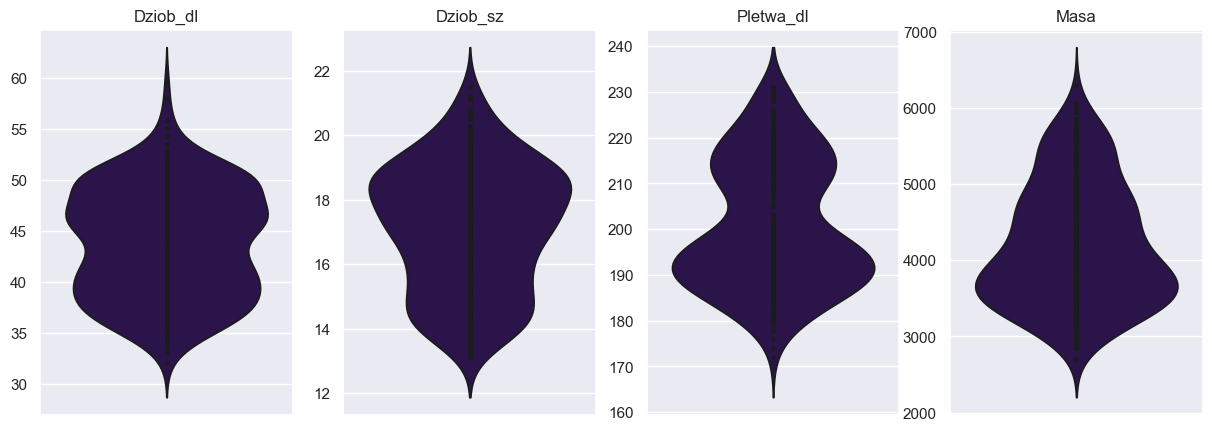

In [11]:
# Wykresy skrzypcowe dla wizualizacji rozkładów zmiennych numerycznych
num_vars = df.select_dtypes(include='number')
fig, axes = plt.subplots(nrows=1, ncols=len(num_vars.columns), figsize=(15, 5), sharey=False)
for i, column in enumerate(num_vars.columns):
    sns.violinplot(data=num_vars, y=column, ax=axes[i], inner="point")
    axes[i].set_title(column)
    axes[i].set_ylabel("")
plt.show()

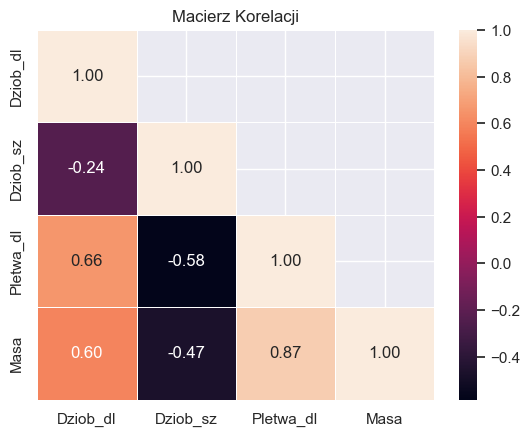

In [12]:
from pandas.plotting import scatter_matrix
correlation_matrix = df.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))
masked_correlation_matrix = correlation_matrix.mask(mask).where(abs(correlation_matrix) > 0.2) #dostosowanie maski zakrywającej nieistotne korelacje
np.fill_diagonal(masked_correlation_matrix.values, 1)
sns.heatmap(masked_correlation_matrix, annot=True, fmt=".2f", linewidths=0.5)
plt.title('Macierz Korelacji')
plt.show()

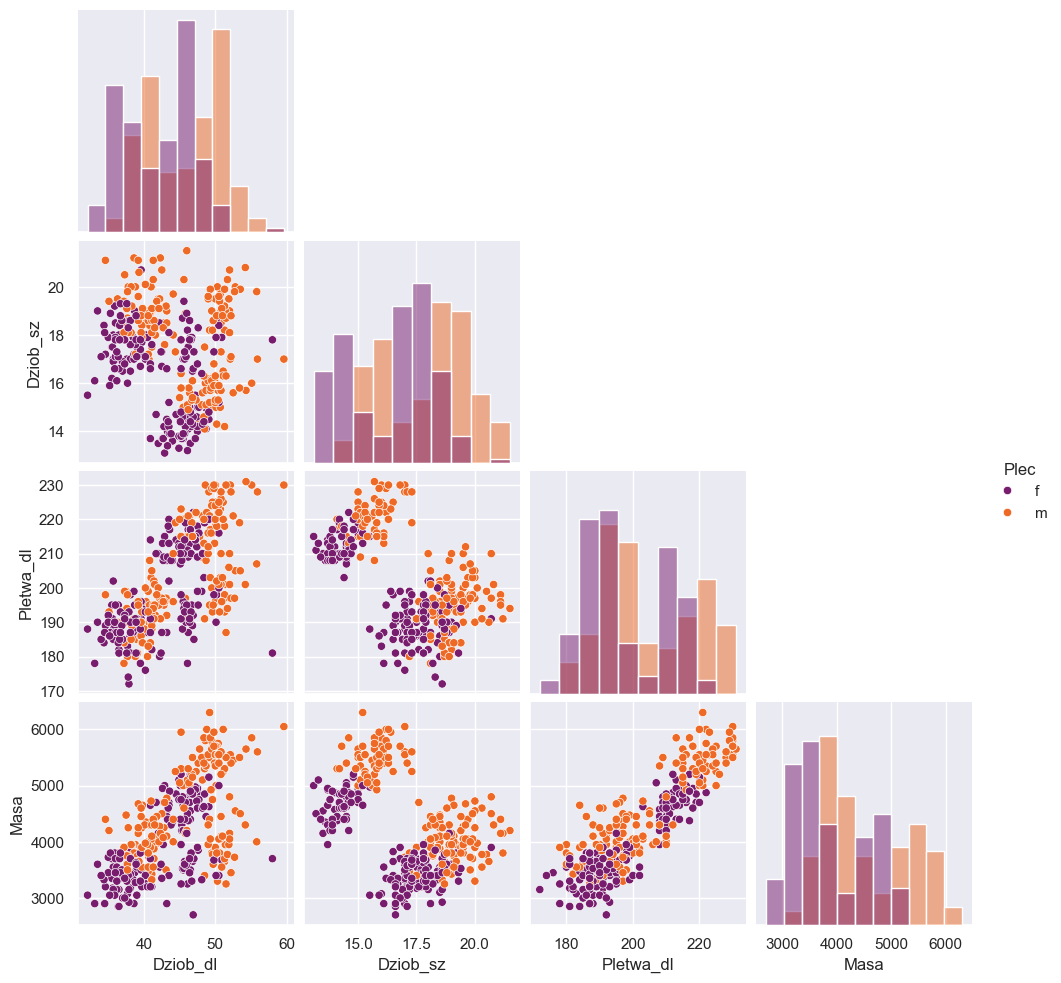

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tworzenie macierzy wykresów rozrzutu z kolorami według kolumny 'Plec'
sns.pairplot(df, hue='Plec', diag_kind='hist', palette='inferno', corner=True)

# Wyświetlenie wykresu
plt.show()


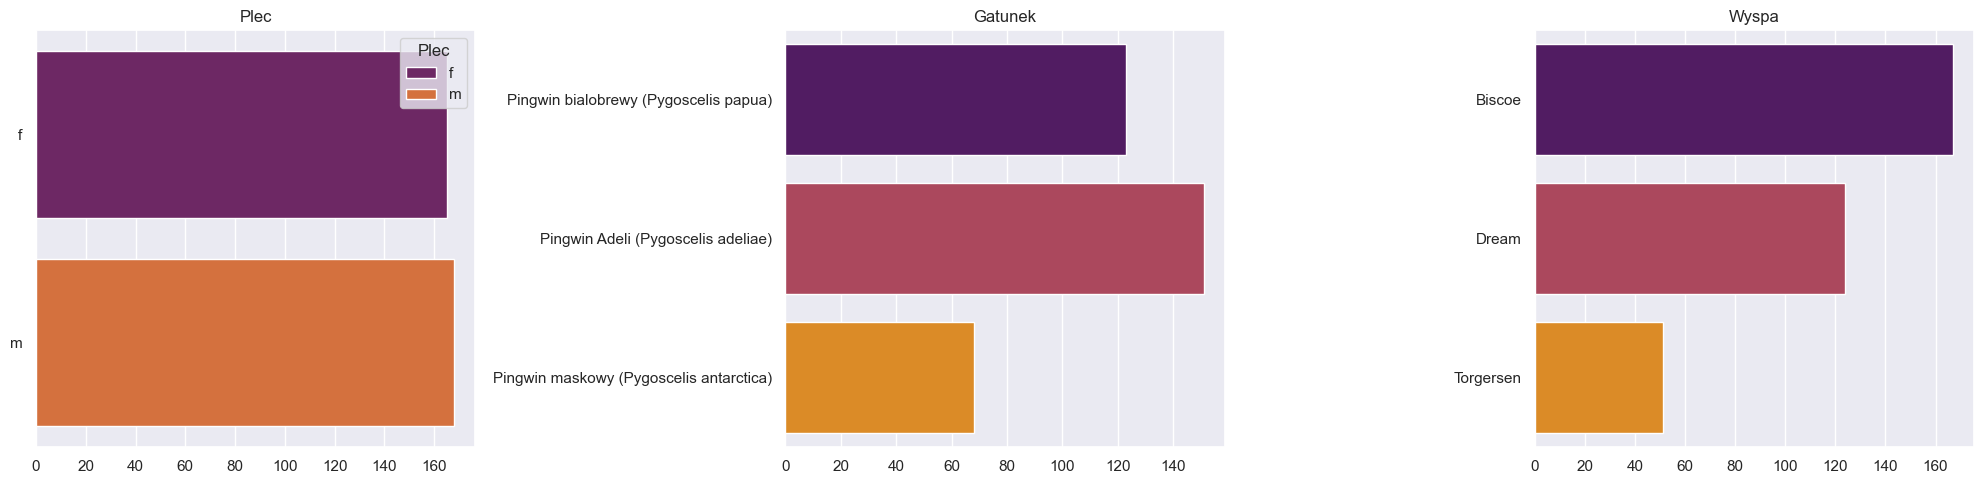

In [14]:
# Tworzenie wykresów słupkowych dla kolumn "Plec", "Gatunek", "Wyspa"
categorical_columns = ['Plec', 'Gatunek', 'Wyspa']
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_columns), figsize=(20, 5))

for i, column in enumerate(categorical_columns):
    sns.countplot(data=df, y=column, ax=axes[i], orient='h',hue = column,palette='inferno')
    axes[i].set_title(f"{column}")
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")

plt.tight_layout()
plt.show()

### Definiowanie potoku przetwarzającego

In [15]:
from sklearn.model_selection import train_test_split

# Podział danych na zestawy treningowy i testowy
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
train_labels, test_labels = train_set['Masa'],test_set['Masa']
train_set,test_set = train_set.drop('Masa',axis=1), test_set.drop('Masa',axis=1)


In [16]:
#Zdefiniowanie potoku przetwarzającego
sklearn.sklearn.set_config(display='diagram')
numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns #tworzenie listy nazw kolumn numerycznych
categorical_columns = df.select_dtypes(include=["object", "category"]).columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import make_column_selector,make_column_transformer
# no właśnie, jaka strategia? trzeba najpierw poznać dane....
num_pipeline = make_pipeline(KNNImputer(),  #zastępuje każdą brakującą wartość średnią z k-najbliższych sąsiadów dla tej cechy
                             StandardScaler())  #standaryzacja zmiennych
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OneHotEncoder(handle_unknown="ignore"))
#Aby uniknąć tworzenia listy nazw kolumn można użyć make_column_selector do automatycznego użycia danego typu zmiennej
#make_column_transformer pozwoli uniknąć tworzenia nazw transformatorów
preprocessing = make_column_transformer(
        (num_pipeline, make_column_selector(dtype_include=np.number)),
        (cat_pipeline, make_column_selector(dtype_exclude=np.number))
)


In [17]:
train_set_prepared = preprocessing.fit_transform(train_set)

#### Regresja liniowa

In [18]:
from sklearn.linear_model import LinearRegression
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(train_set, train_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025CDC243610>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025CDC2436A0>)])),
                ('linearregression', LinearRegression())])

In [19]:
from sklearn.metrics import r2_score, root_mean_squared_error
lin_rmse = root_mean_squared_error(train_labels, lin_reg.predict(train_set)),
lin_r2 = r2_score(train_labels, lin_reg.predict(train_set))

In [20]:
#Sprawdzenie która z kategorii została wykorzystana w pipeline jako bazowa
# Pobranie OneHotEncoder z pipeline
encoder = lin_reg.named_steps['columntransformer'].named_transformers_['pipeline-2'].named_steps['onehotencoder']

# Wyświetlenie kategorii dla każdej zmiennej kategorycznej - domyślnie pierwsza w kolejności to kategoria bazowa, więc Pingwin Adeli
print(encoder.categories_[0][0])

Pingwin Adeli (Pygoscelis adeliae)


In [21]:
print(f"Pierwiastek błędu średniokwadratowego: {lin_rmse},"
      f"Współczynnik R^2: {lin_r2}")

Pierwiastek błędu średniokwadratowego: (297.9526209124777,),Współczynnik R^2: 0.8602442760848223


In [22]:
# Nazwy cech
feature_names = lin_reg.named_steps['columntransformer'].get_feature_names_out()
# Współczynniki
coefficients = lin_reg.named_steps['linearregression'].coef_
# Stworzenie tabeli
coeff_df = pd.DataFrame({
    'Zmienna': feature_names,
    'Beta': coefficients
})
coeff_df['Zmienna'] = coeff_df['Zmienna'].str.replace(r'^.*__', '', regex=True)
print(coeff_df.sort_values(by='Beta', ascending=False))



                                            Zmienna        Beta
4     Gatunek_Pingwin bialobrewy (Pygoscelis papua)  717.105190
2                                         Pletwa_dl  225.224355
0                                          Dziob_dl  167.841829
10                                           Plec_m  161.331932
1                                          Dziob_sz  142.755513
6                                      Wyspa_Biscoe   39.399619
7                                       Wyspa_Dream   17.345468
8                                   Wyspa_Torgersen  -56.745087
9                                            Plec_f -161.331932
3        Gatunek_Pingwin Adeli (Pygoscelis adeliae) -169.349501
5   Gatunek_Pingwin maskowy (Pygoscelis antarctica) -547.755689


In [23]:
# Biblioteka scikit learn nie udostępnia bezpośrednio statystyki dotyczących wartości p, ani istotności poszczególnych zmiennych. W związku z tym korzystam jako alternatywy ze statsmodels

import statsmodels.api as sm

# Dodanie wyrazu wolnego - w przeciwieństwie do scikit learn statsmodels nie dodaje domyślnie wartości wyrazu wolnego
X_train_with_intercept = sm.add_constant(train_set_prepared)
model_sm = sm.OLS(train_labels, X_train_with_intercept).fit()
#Wyniki
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                   Masa   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     203.1
Date:                Wed, 15 Jan 2025   Prob (F-statistic):          3.96e-108
Time:                        00:08:13   Log-Likelihood:                -1942.6
No. Observations:                 273   AIC:                             3903.
Df Residuals:                     264   BIC:                             3936.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1893.3398     11.769    160.870      0.0

### Test

In [24]:
Y_test,X_test = (
    test_labels.copy(),
    test_set.copy()
)
test_predictions = lin_reg.predict(X_test)
test_RMSE = root_mean_squared_error(Y_test,test_predictions)
test_R2 = r2_score(Y_test,test_predictions)
print(f" Pierwiastek błędu średniokwadratowego:  {test_RMSE}",
      f"Współczynnik R^2: {test_R2}")

 Pierwiastek błędu średniokwadratowego:  273.5391655144097 Współczynnik R^2: 0.8859282521144825


Text(0.5, 0, '')

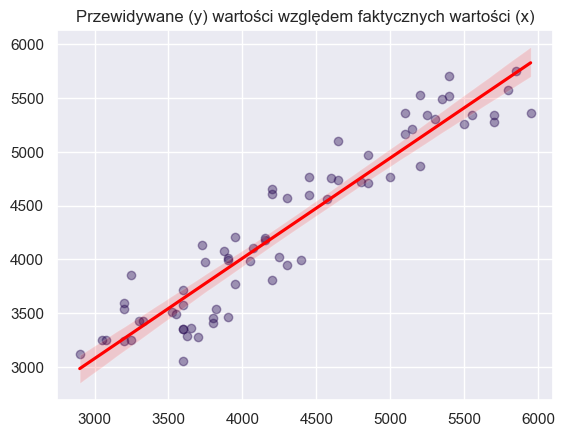

In [25]:
model_effectivness_plot = sns.regplot(
    y = test_predictions,
    x = Y_test,
    scatter_kws= {"alpha":0.4},
    line_kws={'color': 'red'},
)
model_effectivness_plot.set_title("Przewidywane (y) wartości względem faktycznych wartości (x)")
model_effectivness_plot.set_xlabel("")

### Interpretacja

In [28]:
print(f"""
Wartość RMSE = {test_RMSE} oznacza, że średnie odchylenie między wartościami rzeczywistymi a przewidywanymi dla danych testowych wynosi około {test_RMSE.__format__(".2f")} gramów. Porównując ze średnią wartością w badanej próbie, odchylenie to wynosi {(test_RMSE/df['Masa'].mean()*100).__format__(".2f")}%, a więc błąd jest stosunkowo nieduży.\n
Wartość R^2 {test_R2.__format__(".2f")} wskazuje na poziom wariancji zmiennej zależnej wyjaśnianej przez model. Wynik bliski 0.9 wskazuje na wysoką wartość predykcyjną.
\nNiska wartość p {model_sm.f_pvalue}dla statystyki F (3.96e-108) sugeruje, że model jest statystycznie istotny.
\nWartość stałej {model_sm.conf_int().iloc[0][0]} wskazuje jaka jest wartość bazowa gdyby pominąć wpływ wszystkich zmiennych.
\nW przypadku zmiennych numerycznych, np. długości płetwy, współczynnik beta równy {coeff_df['Beta'].loc[coeff_df['Zmienna']=='Pletwa_dl'].values[0].__format__(".2f")} wskazuje, że zgodnie z modelem wzrost długości o 1mm wiąże się ze wzrostem masy pingwina o tę wartość.
\nZnaczącym czynnikiem dla przewidywania masy pingwina jest gatunek - fakt bycia p. białobrewym łączy się z masą większą o {coeff_df['Beta'].loc[coeff_df['Zmienna']=='Gatunek_Pingwin bialobrewy (Pygoscelis papua)'].values[0].__format__(".2f")} zaś bycie p. maskowym powoduje masę mniejszą o {coeff_df['Beta'].loc[coeff_df['Zmienna']=='Gatunek_Pingwin maskowy (Pygoscelis antarctica)'].values[0].__format__(".2f")}
""")


Wartość RMSE = 273.5391655144097 oznacza, że średnie odchylenie między wartościami rzeczywistymi a przewidywanymi dla danych testowych wynosi około 273.54 gramów. Porównując ze średnią wartością w badanej próbie, odchylenie to wynosi 6.51%, a więc błąd jest stosunkowo nieduży.

Wartość R^2 0.89 wskazuje na poziom wariancji zmiennej zależnej wyjaśnianej przez model. Wynik bliski 0.9 wskazuje na wysoką wartość predykcyjną.

Niska wartość p 3.957168111503241e-108dla statystyki F (3.96e-108) sugeruje, że model jest statystycznie istotny.

Wartość stałej 1870.1660557442224 wskazuje jaka jest wartość bazowa gdyby pominąć wpływ wszystkich zmiennych.

W przypadku zmiennych numerycznych, np. długości płetwy, współczynnik beta równy 225.22 wskazuje, że zgodnie z modelem wzrost długości o 1mm wiąże się ze wzrostem masy pingwina o tę wartość.

Znaczącym czynnikiem dla przewidywania masy pingwina jest gatunek - fakt bycia p. białobrewym łączy się z masą większą o 717.11 zaś bycie p. maskowym powod

### Testowanie założenia o homoschedastyczności

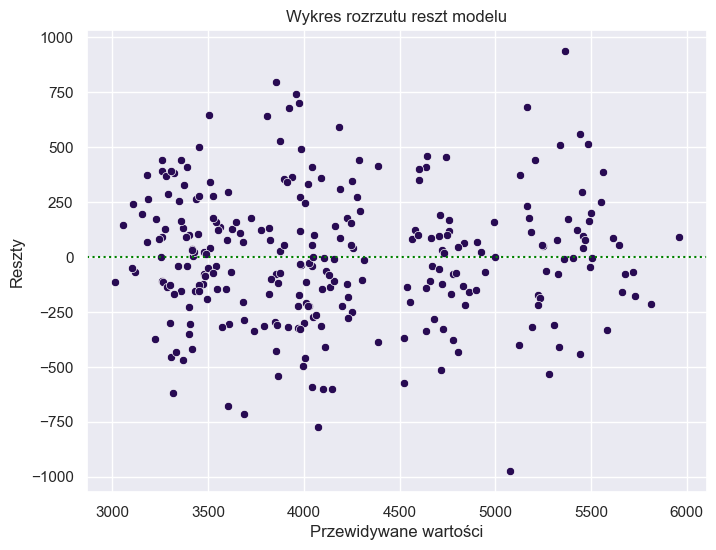

In [29]:
# Przewidywane wartości
predictions = lin_reg.predict(train_set)
# Reszty - różnica między rzeczywistymi a przewidywanymi wartościami
residuals = train_labels - predictions

plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions, y=residuals)
plt.axhline(y=0, color='g', linestyle=':')
plt.title("Wykres rozrzutu reszt modelu")
plt.xlabel("Przewidywane wartości")
plt.ylabel("Reszty")
plt.show()


In [30]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.tools import add_constant

# Dodanie stałej do danych wejściowych
X_with_const = add_constant(train_set_prepared)

# Test Breuscha-Pagana na heteroskedastyczność
bp_test = het_breuschpagan(residuals, X_with_const)

# Wyniki testu: statystyka testowa i wartość p
bp_test_statistic, bp_test_p_value = bp_test[0], bp_test[1]
print(f"Test Breuscha-Pagana: statystyka = {bp_test_statistic}, p-value = {bp_test_p_value}")
print("Wartość p wynosząca 0.1596 sugeruje, że model nie wykazuje heteroskedastyczności. Ponieważ nie ma statystycznie istotnych dowodów na obecność zmiennej wariancji reszt, można założyć homoskedastyczność.")

Test Breuscha-Pagana: statystyka = 15.526514878182498, p-value = 0.15963876379747316
Wartość p wynosząca 0.1596 sugeruje, że model nie wykazuje heteroskedastyczności. Ponieważ nie ma statystycznie istotnych dowodów na obecność zmiennej wariancji reszt, można założyć homoskedastyczność.


Dokonaj predykcji modelu dla przypadku:
pingwin maskowy,
samiec,
długośc dzioba 46 mm,
szerokość 21 mm,
długość płetwy 210 mm.

In [31]:
przypadek = {
'Plec': ['m'],
'Dziob_dl': [46],
'Dziob_sz': [21],
'Pletwa_dl': [210],
'Gatunek': ["Pingwin maskowy (Pygoscelis antarctica)"],
'Wyspa': [None]
}
przypadek_df = pd.DataFrame(przypadek)
predykcja = lin_reg.predict(przypadek_df)
print(f'Predykcja: {predykcja}')


Predykcja: [4207.02715426]


### Model konkurencyjny:

In [32]:
df_2 = df.select_dtypes(include=["number"])

In [33]:
df_2

,Dziob_dl,Dziob_sz,Pletwa_dl,Masa
0,42.0,13.5,210,4150
1,46.5,13.5,210,4550
2,47.5,14.0,212,4875
3,43.3,14.0,208,4575
4,45.5,14.5,212,4750
...,...,...,...,...
337,51.0,18.8,203,4100
338,52.2,18.8,197,3450
339,52.7,19.8,197,3725
340,55.8,19.8,207,4000


In [34]:
from sklearn.linear_model import LinearRegression
# Podział danych na zestawy treningowy i testowy
train_set_2, test_set_2 = train_test_split(df_2, test_size=0.2, random_state=42)

train_labels, test_labels = train_set_2['Masa'],test_set_2['Masa']

train_set_2,test_set_2 = train_set_2.drop('Masa',axis=1), test_set_2.drop('Masa',axis=1)

lin_reg_2 = make_pipeline(preprocessing, LinearRegression())
lin_reg_2.fit(train_set_2, train_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025CDC243610>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000025CDC2436A0>)])),
                ('linearregression', LinearRegression())])

In [35]:
from sklearn.metrics import r2_score, root_mean_squared_error
lin_rmse = root_mean_squared_error(train_labels, lin_reg_2.predict(train_set_2)),
lin_r2 = r2_score(train_labels, lin_reg_2.predict(train_set_2))
lin_rmse,lin_r2

((401.3659361006481,), 0.7463959373793569)

In [36]:
# Nazwy cech
feature_names_2 = lin_reg_2.named_steps['columntransformer'].get_feature_names_out()
# Współczynniki
coefficients_2 = lin_reg_2.named_steps['linearregression'].coef_
# Stworzenie tabeli
coeff_df_2 = pd.DataFrame({
    'Zmienna': feature_names_2,
    'Beta': coefficients_2
})
coeff_df_2['Zmienna'] = coeff_df_2['Zmienna'].str.replace(r'^.*__', '', regex=True)
print(coeff_df_2.sort_values(by='Beta', ascending=False))



     Zmienna        Beta
2  Pletwa_dl  674.220135
0   Dziob_dl   41.530957
1   Dziob_sz   23.823838


In [37]:
train_set_prepared_2 = preprocessing.fit_transform(train_set_2)
# Dodanie wyrazu wolnego - w przeciwieństwie do scikit learn statsmodels nie dodaje domyślnie wartości wyrazu wolnego
X_train_with_intercept = sm.add_constant(train_set_prepared_2)
model_sm_2 = sm.OLS(train_labels, X_train_with_intercept).fit()
print(model_sm_2.summary())

                            OLS Regression Results                            
Dep. Variable:                   Masa   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     263.9
Date:                Wed, 15 Jan 2025   Prob (F-statistic):           8.20e-80
Time:                        00:09:53   Log-Likelihood:                -2024.0
No. Observations:                 273   AIC:                             4056.
Df Residuals:                     269   BIC:                             4070.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4180.1282     24.472    170.815      0.0

#### Wnioski z porównania:

##### Stworzyłem konkurencyjny model w którym odrzuciłem obecne w zbiorze zmienne nominalne. Otrzymany model stracił na swojej wartości predykcyjnej - R2 zmniejszyło się o około 0.1. Tylko długość płetwy okazała się być istotna statystycznie - zmiana o 1 mm powodowała zmianę masy o 674g.
